In [80]:
import pandas
import matplotlib.pyplot as plt
import seaborn 
import gzip

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
with gzip.GzipFile('../data/exports_cran.csv.gz') as f:
    exports = pandas.read_csv(f, usecols=['repository', 'ref', 'export'])
with gzip.GzipFile('../data/index_cran.csv.gz') as f: 
    packages = pandas.read_csv(f, parse_dates=['time'], usecols=['source', 'repository', 'ref', 'time'])

In [3]:
exports = exports.rename(columns={'repository': 'package', 'ref': 'version', 'export': 'item'})
packages = packages.query('source == "cran"').rename(columns={'repository': 'package', 'ref': 'version'})

In [4]:
packages = (packages
    .groupby(by='package')
    .time
    .agg({'pkg_firstdate': pandas.np.min, 'pkg_lastdate': pandas.np.max})
    .merge(packages, how='left', left_index=True, right_on='package')
    .drop('source', axis=1)
)

exports = exports.merge(packages[['package', 'version', 'time']], on=('package', 'version')).sort_values('time')

In [8]:
by_item = {}
by_version = {}

for package, package_group in exports.groupby('package'):
    created_date = package_group.time.min()
    last_items = set()
        
    for time, time_group in package_group.groupby('time'):        
        items = set(time_group.item)    
        additions = items.difference(last_items)
        deletions = last_items.difference(items)
        last_items = set(items)

        for item in additions:
            by_item.setdefault((package, item), {})
            
            by_item[(package, item)]['added_in'] = time
            by_item[(package, item)]['added_after'] = time - created_date
        for item in deletions:
            by_item[(package, item)]['deleted_in'] = time
            by_item[(package, item)]['deleted_after'] = time - created_date
    
        by_version[(package, time_group['version'].iloc[0])] = {'items': len(items), 
                                          'additions': len(additions), 
                                          'deletions': len(deletions)}

In [9]:
df_by_item = pandas.DataFrame.from_dict(by_item, orient='index')
df_by_version = pandas.DataFrame.from_dict(by_version, orient='index')

# Overview

## Packages and versions

In [20]:
print(len(packages.groupby('package')), 'distinct packages')
print(len(packages.groupby(('package', 'version'))), 'versions')
print('Since {} to {} ({})'
      .format(packages.time.min(), packages.time.max(), packages.time.max() - packages.time.min()))

9568 distinct packages
57530 versions
Since 1997-10-08 19:56:17 to 2016-04-26 20:52:26 (6775 days 00:56:09)


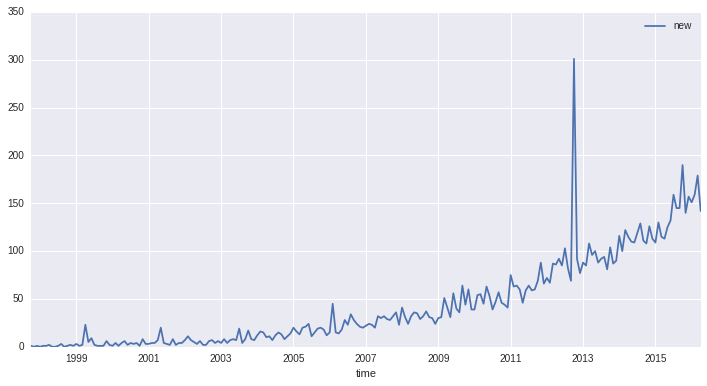

In [81]:
df = packages.groupby('package')[['time']].min().sort_values('time').assign(new=1)
df = df.set_index('time').resample('1M')
ax = df.count().plot()

## Items

In [22]:
print(len(exports.groupby(('package', 'item'))), 'uniquely identified exported items')
print(len(exports.groupby(('package', 'item', 'version'))), 'exported items')

236657 uniquely identified exported items
2072914 exported items


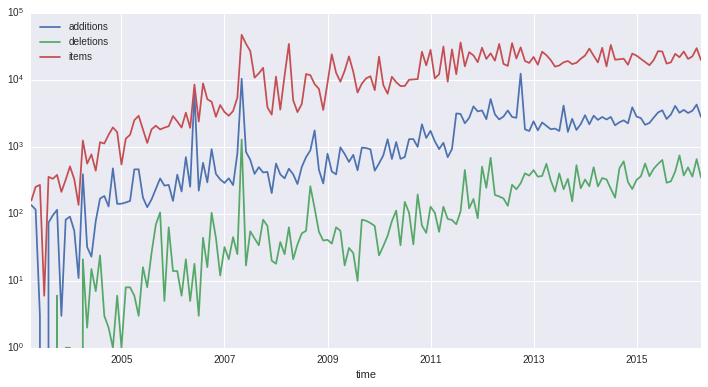

In [82]:
df = df_by_version.merge(packages[['time', 'package', 'version']], left_index=True, right_on=('package', 'version'))
ax = df.set_index('time')[['additions', 'deletions', 'items']].resample('1M').sum().plot(logy=True)

# API changes

## Changes distribution by packages and by versions

##  Changes by dates

## Changes by ages

# API changes correlation

## For packages

## For versions

# Survival analysis

## Deletions since introduction